In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tqdm import tqdm
import json
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [16]:
train_json = '../../data/weedDetection/region-proposals/train.json'
test_json = '../../data/weedDetection/region-proposals/test.json'
images_path = '../../data/weedDetection/Crop-Weed Detection/agri_data/data/'
model_path  = 'RCNN_crop_weed_classification_model.h5'
label_csv = '../../data/weedDetection/pascal_voc_format.csv'
negative_ex_path = '../../data/weedDetection/Train/background/'

In [17]:
with open(train_json,'r') as train:
    train_region = json.load(train)

In [18]:
with open(test_json,'r') as test:
    test_region = json.load(test)

In [19]:
train_images_list = list(train_region.keys())
test_images_list = list(test_region.keys())

In [20]:
print(len(train_images_list))
print(len(test_images_list))

1000
300


In [21]:
labels = pd.read_csv(label_csv)
labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,agri_0_1009.jpeg,512,512,weed,172,119,449,391
1,agri_0_1017.jpeg,512,512,weed,8,4,500,390
2,agri_0_1018.jpeg,512,512,weed,20,84,434,409
3,agri_0_1020.jpeg,512,512,weed,66,23,440,336
4,agri_0_1024.jpeg,512,512,weed,161,76,453,381


In [22]:
model = tf.keras.models.load_model(model_path)

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [24]:
model_without_last_2FC = tf.keras.models.Model(model.inputs,model.layers[-5].output)

In [25]:
model_without_last_2FC.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

When we pass image from model it will return (1,4096) size feature vector

In [26]:
train_features = []

test_features = []


for index in tqdm(range(len(labels))):
    id = labels.loc[index,'filename']
    img = cv2.imread(images_path + id)
    rgb_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    xmin,ymin,xmax,ymax = int(labels.loc[index,'xmin']) ,int(labels.loc[index,'ymin']),int(labels.loc[index,'xmax']),int(labels.loc[index,'ymax'])

    resized = cv2.resize(rgb_img[ymin:ymax,xmin:xmax,:],(224,224))

    feature_of_img = model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255)
    
    if id in train_images_list:
        train_features.append([feature_of_img,labels.loc[index,'class']])
        
    else:
        test_features.append([feature_of_img,labels.loc[index,'class']])
      

100%|██████████| 2072/2072 [09:33<00:00,  3.62it/s]


In [27]:
print(len(train_features))
print(len(test_features))


1637
435


In [28]:
for index,img in tqdm(enumerate(os.listdir(negative_ex_path)[:5000])):  #only extracting for 10,000 images
    img = cv2.imread(negative_ex_path + img )
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #images already in (224,224,3)
    feature_of_img = model_without_last_2FC.predict(rgb.reshape(1,224,224,3)/255)
    if index<3500:
        train_features.append([feature_of_img,'background'])
    else:
        test_features.append([feature_of_img,'background'])

5000it [23:53,  3.49it/s]


In [29]:
import random
random.shuffle(train_features)

In [30]:
X_train = np.array([x[0] for x in train_features])
X_train = X_train.reshape(-1,4096)

In [31]:
X_train.shape

(5137, 4096)

In [32]:
y_train = [x[1] for x in train_features]
y_train = np.array(y_train).reshape(-1,1)

In [33]:
y_train.shape

(5137, 1)

In [34]:
X_test = np.array([x[0] for x in test_features])
X_test = X_test.reshape(-1,4096)

In [35]:
y_test = [x[1] for x in test_features]
y_test = np.array(y_test).reshape(-1,1)

In [36]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [37]:
svm_model_linear = SVC(kernel = 'linear', C = 1,probability=True).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test)

In [38]:
accuracy = svm_model_linear.score(X_test, y_test)

In [39]:
accuracy

0.9705426356589147

In [40]:
cm = confusion_matrix(y_test, svm_predictions) 

<AxesSubplot:>

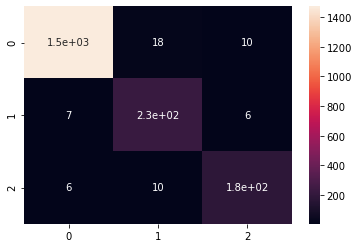

In [41]:
sns.heatmap(cm,annot=True)

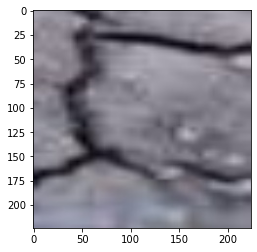

In [42]:
img = cv2.imread(negative_ex_path + os.listdir(negative_ex_path)[45] )
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

In [43]:
feature_of_img = model_without_last_2FC.predict(rgb.reshape(1,224,224,3)/255)

In [44]:
svm_model_linear.predict(feature_of_img)

array(['background'], dtype='<U10')

In [45]:
svm_model_linear.predict_proba(feature_of_img)

array([[9.99102958e-01, 5.26453418e-05, 8.44396764e-04]])

In [46]:
svm_model_linear.classes_

array(['background', 'crop', 'weed'], dtype='<U10')

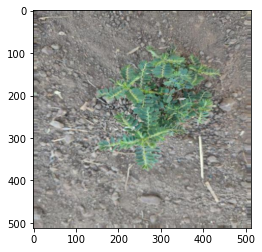

In [47]:
img = cv2.imread(images_path+'agri_0_1024.jpeg')
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

In [48]:
resized = cv2.resize(rgb,(224,224))

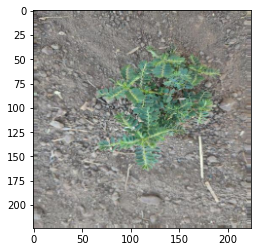

In [49]:
plt.imshow(resized)

In [50]:
svm_model_linear.predict_proba(model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255))

array([[0.08126202, 0.0099999 , 0.90873808]])

In [51]:
import pickle

with open('svm_classifier.pkl','wb') as svm_model:
    pickle.dump(svm_model_linear , svm_model)